In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , Model

In [2]:
from tensorflow.keras.models import load_model

In [3]:
coded_filtered_dataset_v2 = np.load('coded_filtered_dataset_v2.npy',allow_pickle=True)

In [4]:
# hard coded definitions of categorical fields in the "coded_filtered_dataset_v2"
colname_to_int = {
    'away_club_id' : 211, #fourth last
    'home_club_id' : 210, #fifth last etc.
    'away_player_11_id' : 201,
    'away_player_11_pos' : 202,
    'away_player_10_id': 192,
    'away_player_10_pos': 193,
    'away_player_9_id' : 183,
    'away_player_9_pos' : 184,
    'away_player_8_id': 174,
    'away_player_8_pos': 175,
    'away_player_7_id': 165,
    'away_player_7_pos': 166,
    'away_player_6_id': 156,
    'away_player_6_pos': 157,
    'away_player_5_id': 147,
    'away_player_5_pos': 148,
    'away_player_4_id': 138,
    'away_player_4_pos': 139,
    'away_player_3_id': 129,
    'away_player_3_pos': 130,
    'away_player_2_id': 120,
    'away_player_2_pos': 121,
    'away_player_1_id': 111,
    'away_player_1_pos': 112,
    'home_player_11_id': 102,
    'home_player_11_pos': 103,
    'home_player_10_id': 93,
    'home_player_10_pos': 94,
    'home_player_9_id': 84,
    'home_player_9_pos': 85,
    'home_player_8_id': 75,
    'home_player_8_pos': 76,
    'home_player_7_id': 66,
    'home_player_7_pos': 67,
    'home_player_6_id': 57,
    'home_player_6_pos': 58,
    'home_player_5_id': 48,
    'home_player_5_pos': 49,
    'home_player_4_id': 39,
    'home_player_4_pos': 40,
    'home_player_3_id': 30,
    'home_player_3_pos': 31,
    'home_player_2_id': 21,
    'home_player_2_pos': 22,
    'home_player_1_id': 12,
    'home_player_1_pos': 13,
}

In [5]:
categorical_columns = list(colname_to_int.values())
numerical_columns = [i for i in range(coded_filtered_dataset_v2[-1].shape[0]) if i not in categorical_columns]

In [6]:
def build_embedding_model(
    num_clubs=1000000,
    num_players=1000000,
    num_positions=16,
    emb_dim_club=4,
    emb_dim_player=4,
    emb_dim_pos=1,
    num_player_slots=11,
    output_classes=3,
    num_numeric_features=168  # ADDED: how many numeric columns we have
):
    #
    # 1) NUMERIC INPUT
    #
    numeric_input = layers.Input(shape=(num_numeric_features,), name='numeric_input')
    # (Optional: normalization or dense transformation)
    normalizer = layers.Normalization(name="numeric_normalizer", axis=-1)
    x_numeric = normalizer(numeric_input)  # or pass through layers as above
    print("Normalization mean:", normalizer.mean.numpy())
    print("Normalization variance:", normalizer.variance.numpy())

    #
    # 2) CATEGORICAL INPUTS (same as before)
    #
    away_club_in = layers.Input(shape=(1,), name='away_club_id', dtype='int32')
    home_club_in = layers.Input(shape=(1,), name='home_club_id', dtype='int32')

    away_player_inputs_id = []
    away_player_inputs_pos = []
    home_player_inputs_id = []
    home_player_inputs_pos = []

    for i in range(1, num_player_slots + 1):
        away_player_inputs_id.append(
            layers.Input(shape=(1,), name=f'away_player_{i}_id', dtype='int32')
        )
        away_player_inputs_pos.append(
            layers.Input(shape=(1,), name=f'away_player_{i}_pos', dtype='int32')
        )
        home_player_inputs_id.append(
            layers.Input(shape=(1,), name=f'home_player_{i}_id', dtype='int32')
        )
        home_player_inputs_pos.append(
            layers.Input(shape=(1,), name=f'home_player_{i}_pos', dtype='int32')
        )

    #
    # 3) DEFINE EMBEDDING LAYERS
    #
    club_embedding_layer = layers.Embedding(
        input_dim=num_clubs,
        output_dim=emb_dim_club,
        name='club_embedding'
    )
    player_embedding_layer = layers.Embedding(
        input_dim=num_players,
        output_dim=emb_dim_player,
        name='player_embedding'
    )
    position_embedding_layer = layers.Embedding(
        input_dim=num_positions,
        output_dim=emb_dim_pos,
        name='position_embedding'
    )

    #
    # 4) PASS INPUTS THROUGH EMBEDDINGS
    #
    away_club_emb = club_embedding_layer(away_club_in)
    home_club_emb = club_embedding_layer(home_club_in)

    away_club_emb = layers.Flatten()(away_club_emb)
    home_club_emb = layers.Flatten()(home_club_emb)

    away_player_embs_id = [player_embedding_layer(inp) for inp in away_player_inputs_id]
    away_player_embs_id = [layers.Flatten()(emb) for emb in away_player_embs_id]

    #away_player_embs_pos = [position_embedding_layer(inp) for inp in away_player_inputs_pos]
    #away_player_embs_pos = [layers.Flatten()(emb) for emb in away_player_embs_pos]

    home_player_embs_id = [player_embedding_layer(inp) for inp in home_player_inputs_id]
    home_player_embs_id = [layers.Flatten()(emb) for emb in home_player_embs_id]

    #home_player_embs_pos = [position_embedding_layer(inp) for inp in home_player_inputs_pos]
    #home_player_embs_pos = [layers.Flatten()(emb) for emb in home_player_embs_pos]

    print("Away club embedding shape:", away_club_emb.shape)
    print("Player embedding shapes:", [emb.shape for emb in away_player_embs_id[:2]])
    #print("Position embedding shapes:", [emb.shape for emb in away_player_embs_pos[:2]])
    #
    # 5) CONCATENATE EMBEDDINGS
    #
    concat_list = [away_club_emb, home_club_emb] \
                  + away_player_embs_id + home_player_embs_id # + away_player_embs_pos
                   #+ home_player_embs_pos

    x_cat = layers.Concatenate()(concat_list)
    print("Embedding concatenation shape:", x_cat.shape)
    #
    # 6) CONCATENATE WITH NUMERIC FEATURES
    #
    # Now we combine the categorical embedding vector x_cat with x_numeric
    #
    x = layers.Concatenate()([x_cat, x_numeric])
    print("Final concatenation shape:", x.shape)
    #
    # 7) ADD FINAL DENSE LAYERS
    #
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(output_classes, activation='sigmoid')(x)

    #
    # 8) BUILD MODEL
    #
    # Collect all the inputs into one list
    all_inputs = (
        [numeric_input, away_club_in, home_club_in]
        + away_player_inputs_id
        + away_player_inputs_pos
        + home_player_inputs_id
        + home_player_inputs_pos
    )

    model = keras.Model(inputs=all_inputs, outputs=output)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [7]:
model = build_embedding_model()

Normalization mean: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Normalization variance: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [8]:
import numpy as np

def row_to_model_input(
    row: np.ndarray,
    colname_to_int: dict,
    max_cols_num: int
):
    embedding_columns = list(colname_to_int.values())
    numeric_columns = [i for i in range(max_cols_num) if i not in embedding_columns]

    #print("Number of numeric columns being used:", len(numeric_columns))
    #all_cols = set(colname_to_int.keys())
    #embedding_cols_set = set(embedding_columns)

    # 1) Identify numeric columns (everything not in embedding_columns)
    #numeric_columns = [c for c in all_cols if c not in embedding_cols_set]
    #numeric_columns = sorted(numeric_columns)  # optional: ensure stable order

    # 2) Build the numeric_input array
    numeric_vals = []
    for idx in numeric_columns:
        #idx = colname_to_int[col]
        numeric_vals.append(row[idx])
    # shape (1, num_numeric_features)
    numeric_vals = np.array([numeric_vals], dtype="float32")

    # 3) Build the dict for each categorical column
    model_input = {
        "numeric_input": numeric_vals
    }

    #for cat_idx in embedding_columns:
    for col, idx in colname_to_int.items():
        #idx = colname_to_int[cat_col]
        cat_val = row[idx]
        # Make it shape (1,1) for batch_size=1
        cat_arr = np.array([[cat_val]], dtype="int32")

        # Key must match the model’s Input layer name
        model_input[col] = cat_arr
    return model_input


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding


In [10]:
model = build_embedding_model()
model.summary()

Normalization mean: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Normalization variance: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [11]:
model_layers = Model(inputs=model.input, outputs=model.get_layer('concatenate_5').output)
sample_output = model_layers.predict(model_input_dict)
print("Concatenate output shape:", sample_output.shape)  # Should be (1, 624)


ValueError: No such layer: concatenate_5.

In [12]:
#del model
model = build_embedding_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Normalization mean: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Normalization variance: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [13]:

# Your single example (1D array):
row = np.random.randint(low=0, high=16, size=(214,))  # or however many

# Now convert:
model_input_dict = row_to_model_input(
    row=row,
    colname_to_int=colname_to_int,
    max_cols_num=row.shape[0]
)

# Get the correct input order from the model
correct_order = [input_layer.name for input_layer in model.input]

# Reorder the input dictionary based on the correct order
ordered_model_input_dict = {key: model_input_dict[key] for key in correct_order}

# Now feed into your model for prediction:
prediction = model.predict(model_input_dict)
print("Predicted:", prediction)


Predicted: [[9.9809927e-01 6.8382255e-04 9.5125449e-01]]


In [14]:
def simple_encode(y):
  if y == -1:
    return [0,0,1]
  elif y == 0:
    return [0,1,0]
  else:
    return [1,0,0]

In [15]:
from sklearn.model_selection import train_test_split

X = [row_to_model_input(row,colname_to_int,max_cols_num=214) for row in coded_filtered_dataset_v2]
y = [row[-1] for row in coded_filtered_dataset_v2]
y = [ simple_encode(row) for row in y]
y = np.array(y)
X_train, X_test =  train_test_split(X, test_size =.20, shuffle=False)
y_train, y_test = train_test_split(y,test_size=.20,shuffle=False)

In [16]:

def convert_list_of_dicts_to_dict_of_arrays_old(data_list):
    if not data_list:
        raise ValueError("Input data_list is empty")

    keys = data_list[0].keys()
    for item in data_list:
        if item.keys() != keys:
            raise ValueError("All dictionaries must have the same keys")

    output_dict = {key: np.array([np.squeeze(d[key]) for d in data_list]) for key in keys}
    return output_dict


In [17]:
def convert_list_of_dicts_to_dict_of_arrays(data_list):
    if not data_list:
        raise ValueError("Input data_list is empty")

    # Ensure all dictionaries have the same keys
    keys = data_list[0].keys()
    for item in data_list:
        if item.keys() != keys:
            raise ValueError("All dictionaries must have the same keys")

    output_dict = {}

    for key in keys:
        # Stack values into a NumPy array
        array_data = np.array([np.squeeze(d[key]) for d in data_list])

        # Handle NaN values by replacing them with zeros
        if np.isnan(array_data).any():
            print(f"NaN detected in {key}, replacing with 0.")
            array_data = np.nan_to_num(array_data, nan=0.0)

        # Reshape categorical inputs (assumes they should be 2D)
        if array_data.ndim == 1:
            array_data = array_data.reshape(-1, 1)

        # Set correct data type: float32 for numeric, int32 for categorical
        if 'numeric_input' in key:
            array_data = array_data.astype(np.float32)
        else:
            array_data = array_data.astype(np.int32)

        output_dict[key] = array_data

    return output_dict

In [18]:
X_train = convert_list_of_dicts_to_dict_of_arrays(X_train)
X_test = convert_list_of_dicts_to_dict_of_arrays(X_test)

NaN detected in numeric_input, replacing with 0.
NaN detected in numeric_input, replacing with 0.


In [19]:
X_2 = convert_list_of_dicts_to_dict_of_arrays(X)

NaN detected in numeric_input, replacing with 0.


In [20]:
#np.save('converted_dataset_X.npy',X_2)

In [21]:
#np.save('converted_dataset_Y.npy',y)
import pickle
with open('converted_dataset_X.pkl','wb') as f:
  pickle.dump(X_2, f)
with open('converted_dataset_Y.pkl','wb') as f:
  pickle.dump(y, f)

In [22]:
len(X_train)

47

In [23]:
for key, value in X_train.items():
    if np.isnan(value).any():
        X_train[key] = np.nan_to_num(value, nan=np.nanmean(value))  # Replace NaN with mean


In [24]:
for key, value in X_train.items():
    print(f"Key: {key}, Shape: {value.shape}")


Key: numeric_input, Shape: (3696, 168)
Key: away_club_id, Shape: (3696, 1)
Key: home_club_id, Shape: (3696, 1)
Key: away_player_11_id, Shape: (3696, 1)
Key: away_player_11_pos, Shape: (3696, 1)
Key: away_player_10_id, Shape: (3696, 1)
Key: away_player_10_pos, Shape: (3696, 1)
Key: away_player_9_id, Shape: (3696, 1)
Key: away_player_9_pos, Shape: (3696, 1)
Key: away_player_8_id, Shape: (3696, 1)
Key: away_player_8_pos, Shape: (3696, 1)
Key: away_player_7_id, Shape: (3696, 1)
Key: away_player_7_pos, Shape: (3696, 1)
Key: away_player_6_id, Shape: (3696, 1)
Key: away_player_6_pos, Shape: (3696, 1)
Key: away_player_5_id, Shape: (3696, 1)
Key: away_player_5_pos, Shape: (3696, 1)
Key: away_player_4_id, Shape: (3696, 1)
Key: away_player_4_pos, Shape: (3696, 1)
Key: away_player_3_id, Shape: (3696, 1)
Key: away_player_3_pos, Shape: (3696, 1)
Key: away_player_2_id, Shape: (3696, 1)
Key: away_player_2_pos, Shape: (3696, 1)
Key: away_player_1_id, Shape: (3696, 1)
Key: away_player_1_pos, Shape: (369

In [25]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2)

Epoch 1/10
1848/1848 [==============================] - 17s 9ms/step - loss: 116178.3750 - accuracy: 0.3869
Epoch 2/10
1848/1848 [==============================] - 16s 8ms/step - loss: 24582.2422 - accuracy: 0.4058
Epoch 3/10
1848/1848 [==============================] - 15s 8ms/step - loss: 7643.6348 - accuracy: 0.4264
Epoch 4/10
1848/1848 [==============================] - 15s 8ms/step - loss: 420.8040 - accuracy: 0.4827
Epoch 5/10
1848/1848 [==============================] - 15s 8ms/step - loss: 41.7097 - accuracy: 0.4886
Epoch 6/10
1848/1848 [==============================] - 15s 8ms/step - loss: 91.7868 - accuracy: 0.4843
Epoch 7/10
1848/1848 [==============================] - 15s 8ms/step - loss: 93.4598 - accuracy: 0.4881
Epoch 8/10
1848/1848 [==============================] - 15s 8ms/step - loss: 3.2525 - accuracy: 0.4927
Epoch 9/10
1848/1848 [==============================] - 15s 8ms/step - loss: 1.0461 - accuracy: 0.4938
Epoch 10/10
1848/1848 [==============================] -

In [26]:
from sklearn.metrics import confusion_matrix, f1_score
y_pred = model.predict(X_test)
print(confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))
print(f1_score(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1),average='micro'))

[[394   0   0]
 [224   0   0]
 [306   0   0]]
0.4264069264069264


In [27]:
np.argmax(y_pred,axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
np.argmax(y_test,axis=-1)

array([0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2,
       0, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 1, 0, 2,
       0, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 2,
       0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0,
       1, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2,
       0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 1,
       0, 2, 0, 2, 2, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 2, 0, 1, 1, 2, 2, 0,
       2, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 2, 1, 0, 1,
       0, 1, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2,
       0, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0,
       0, 1, 2, 2, 0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 2, 2, 0,
       0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 2, 2, 1, 1, 0,

In [29]:
model.save('MLP_football_playerdim-4_clubdim-4.keras')

In [30]:
model2 = load_model('MLP_football_playerdim-4_clubdim-4.keras')

In [31]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
away_club_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
home_club_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
away_player_1_id (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
away_player_2_id (InputLayer)   [(None, 1)]          0                                            
____________________________________________________________________________________________

In [32]:
# Lets visualize some embeddings
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

model = load_model('MLP_football_playerdim-4_clubdim-4.keras')
# Assuming 'model' is your trained Keras model
embedding_layer = model.get_layer('club_embedding')  # Replace with your embedding layer name
weights = embedding_layer.get_weights()[0]


print("Embedding shape:", weights.shape)  # (vocab_size, embedding_dim)


Embedding shape: (1000000, 4)


In [33]:
coded_dataset = np.load('coded_filtered_dataset_v2.npy',allow_pickle=True)

In [34]:
#coded_dataset[-1]
club_ids_1 = [row[-4] for row in coded_dataset]
club_ids_2 = [row[-5] for row in coded_dataset]
subset_ids = np.unique(np.concatenate([club_ids_1,club_ids_2]))
subset_embeddings = weights[subset_ids]

In [35]:
subset_embeddings

array([[ 0.33193776,  0.15784825, -0.26675585,  0.28903893],
       [ 0.3225363 ,  0.13977152, -0.24836789,  0.31011787],
       [ 0.02456664,  0.26353177, -0.01407973,  0.02523602],
       [ 0.034658  ,  0.08078935, -0.10955122,  0.05770092],
       [-0.11405414,  0.11445364,  0.03405137, -0.10300806],
       [-0.06744391, -0.00336621,  0.10392521, -0.0919909 ],
       [-0.07205145,  0.10098246, -0.01288006, -0.02149848],
       [ 0.18995783,  0.28467926, -0.2330449 ,  0.15062097],
       [ 0.11692372,  0.2637978 , -0.12548779,  0.01262105],
       [ 0.18315926,  0.3745952 , -0.33912343,  0.24327843],
       [-0.09089373, -0.02122495,  0.10229393, -0.11254691],
       [ 0.03304592,  0.19146736, -0.10981434, -0.0176667 ],
       [ 0.12507191,  0.12750433, -0.07697808,  0.14958446],
       [-0.02892576, -0.07447498,  0.0346025 , -0.00820789],
       [-0.09705117,  0.10287584, -0.01668669, -0.09316052],
       [ 0.6529221 ,  0.5956109 , -0.7639814 ,  0.5678333 ],
       [ 0.00376382,  0.

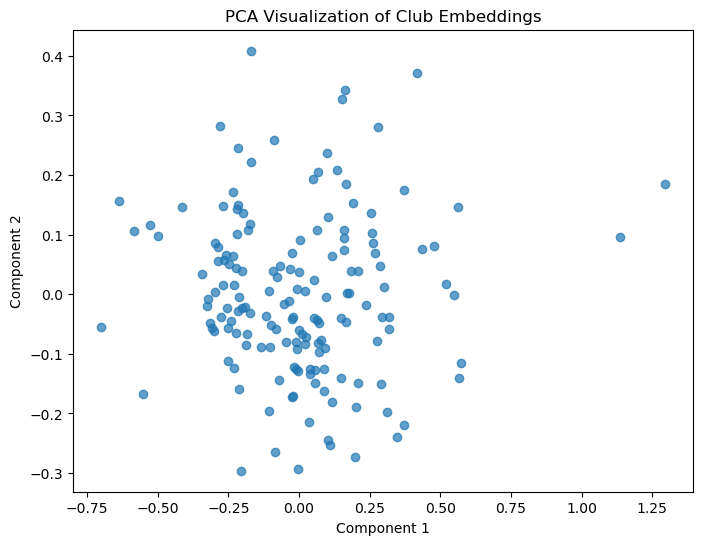

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(subset_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
plt.title('PCA Visualization of Club Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [38]:

X = [row_to_model_input(row,colname_to_int,max_cols_num=214) for row in coded_filtered_dataset_v2]
y = [row[-1] for row in coded_filtered_dataset_v2]
# y = [ simple_encode(row) for row in y]
y = np.array(y)
X_train, X_test =  train_test_split(X, test_size =.20, shuffle=False)
y_train, y_test = train_test_split(y,test_size=.20,shuffle=False)

In [39]:
X_train = convert_list_of_dicts_to_dict_of_arrays(X_train)
X_test = convert_list_of_dicts_to_dict_of_arrays(X_test)

NaN detected in numeric_input, replacing with 0.
NaN detected in numeric_input, replacing with 0.


In [40]:
print(y_test.shape)

(924,)


In [41]:
def data_for_sklearn(dict):
    features = []
    for el in dict.keys():
        features.append(el)
    dict_forsk = np.hstack(dict[feature] for feature in features)
    return dict_forsk

In [149]:
str(X_train.keys()) 

"dict_keys(['numeric_input', 'away_club_id', 'home_club_id', 'away_player_11_id', 'away_player_11_pos', 'away_player_10_id', 'away_player_10_pos', 'away_player_9_id', 'away_player_9_pos', 'away_player_8_id', 'away_player_8_pos', 'away_player_7_id', 'away_player_7_pos', 'away_player_6_id', 'away_player_6_pos', 'away_player_5_id', 'away_player_5_pos', 'away_player_4_id', 'away_player_4_pos', 'away_player_3_id', 'away_player_3_pos', 'away_player_2_id', 'away_player_2_pos', 'away_player_1_id', 'away_player_1_pos', 'home_player_11_id', 'home_player_11_pos', 'home_player_10_id', 'home_player_10_pos', 'home_player_9_id', 'home_player_9_pos', 'home_player_8_id', 'home_player_8_pos', 'home_player_7_id', 'home_player_7_pos', 'home_player_6_id', 'home_player_6_pos', 'home_player_5_id', 'home_player_5_pos', 'home_player_4_id', 'home_player_4_pos', 'home_player_3_id', 'home_player_3_pos', 'home_player_2_id', 'home_player_2_pos', 'home_player_1_id', 'home_player_1_pos'])"

In [42]:
# svm
c = 5
kernel = "rbf"
gamma_svm = 0.2
# random forest
n_estimators = 250
max_depth = 10
min_sample_split = 2
criterion = "log_loss"
# gradient boosting
learning_rate = 0.1
gamma_gb = 0.03
reg_lambda = 0.075
max_depth = 3
loss = 'log_loss'
n_estimators_gb = 150

In [43]:
svm = SVC(C=c,kernel=kernel,gamma=gamma_svm)
random_forest = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_sample_split,criterion=criterion)
gradient_boosting = xgb.XGBClassifier(loss=loss,learning_rate=learning_rate,n_estimators=n_estimators_gb,max_depth=max_depth,gamma=gamma_gb,reg_lambda=reg_lambda)

In [44]:

print(X_train)

{'numeric_input': array([[0. , 0. , 1. , ..., 0. , 0. , 0. ],
       [0.2, 0.2, 1.4, ..., 0. , 0. , 0. ],
       [0.2, 0.4, 1.2, ..., 0. , 0. , 0. ],
       ...,
       [0.6, 0.6, 1.8, ..., 0. , 0. , 0. ],
       [0.6, 1.8, 1.4, ..., 0. , 0. , 0. ],
       [0.6, 1.4, 2.4, ..., 0. , 0. , 0. ]], dtype=float32), 'away_club_id': array([[4146],
       [ 607],
       [4153],
       ...,
       [  19],
       [2721],
       [1103]]), 'home_club_id': array([[19164],
       [ 4333],
       [ 8970],
       ...,
       [ 4083],
       [ 1038],
       [ 1025]]), 'away_player_11_id': array([[273131],
       [274475],
       [274211],
       ...,
       [475410],
       [427653],
       [256659]]), 'away_player_11_pos': array([[ 6],
       [12],
       [ 2],
       ...,
       [12],
       [ 3],
       [15]]), 'away_player_10_id': array([[273126],
       [256205],
       [244061],
       ...,
       [420189],
       [301239],
       [218306]]), 'away_player_10_pos': array([[8],
       [4],
       [4

In [45]:
len(X_train.keys())

47

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
x_train_nn_full = data_for_sklearn(X_train)

x_train_nn,x_val_nn,y_train_nn,y_val_nn = train_test_split(x_train_nn_full,y_train,test_size=0.2,shuffle=False)
y_train_nn = np.array([ simple_encode(row) for row in y_train_nn])
y_val_nn = np.array([simple_encode(row) for row in y_val_nn])
x_train_nn =  np.array(x_train_nn)
x_val_nn =  np.array(x_val_nn)
input_shape=x_train_nn.shape[1]
# input_shape = len(X_train.keys())
match_predictor = Sequential([
        layers.InputLayer(input_shape=input_shape,name="Input layer"),
        layers.Dense(256,activation='swish', kernel_regularizer=l2(0.01),name="Dense_256"),
        layers.Dropout(0.3,name="Dropout_0.3"),
        layers.Dense(128,activation = 'swish',kernel_regularizer=l2(0.01),name="Dense_128"),
        layers.Dropout(0.2,name='Dropout_0.2'),
        layers.Dense(3,activation='softmax',name="output_layer"),
    ])
learning_rate = 0.01
match_predictor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss = 'categorical_crossentropy',metrics='accuracy')
match_predictor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_256 (Dense)            (None, 256)               55040     
_________________________________________________________________
Dropout_0.3 (Dropout)        (None, 256)               0         
_________________________________________________________________
Dense_128 (Dense)            (None, 128)               32896     
_________________________________________________________________
Dropout_0.2 (Dropout)        (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 3)                 387       
Total params: 88,323
Trainable params: 88,323
Non-trainable params: 0
_________________________________________________________________


C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


In [79]:
x_train_nn.shape

(2956, 214)

SVM bez embedingów

In [80]:
svm.fit(data_for_sklearn(X_train),y_train)

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


SVC(C=5, gamma=0.2)

In [81]:
y_pred = svm.predict(data_for_sklearn(X_test))

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


In [82]:
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve,ConfusionMatrixDisplay,f1_score,precision_score,classification_report
import matplotlib.pyplot as plt

In [83]:
svm_acc = accuracy_score(y_test,y_pred)
print(svm_acc)

0.4264069264069264


In [84]:
svm_prec = precision_score(y_test,y_pred,average='weighted')
print(svm_prec)

0.18182286688780197


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
svm_f1 = f1_score(y_test,y_pred,average='weighted')
print(svm_f1)

0.25493828376984673


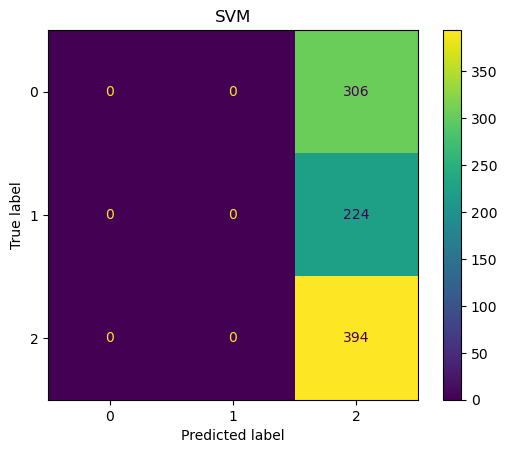

In [86]:
conf_svm = confusion_matrix(y_test,y_pred)
dsp = ConfusionMatrixDisplay(conf_svm)
dsp.plot()
plt.title("SVM")
plt.show()

Random Forest

In [87]:
random_forest.fit(data_for_sklearn(X_train),y_train)

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


RandomForestClassifier(criterion='log_loss', max_depth=3, n_estimators=250)

In [88]:
y_pred = random_forest.predict(data_for_sklearn(X_test))

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


In [89]:
random_forest_acc = accuracy_score(y_test,y_pred)
print(random_forest_acc)

0.49134199134199136


In [90]:
random_forest_prec = precision_score(y_test,y_pred,average='weighted')
print(random_forest_prec)

0.4141279583623386


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [91]:
random_forest_f1_score = f1_score(y_test,y_pred,average='weighted')
print(random_forest_f1_score)

0.3866129165669427


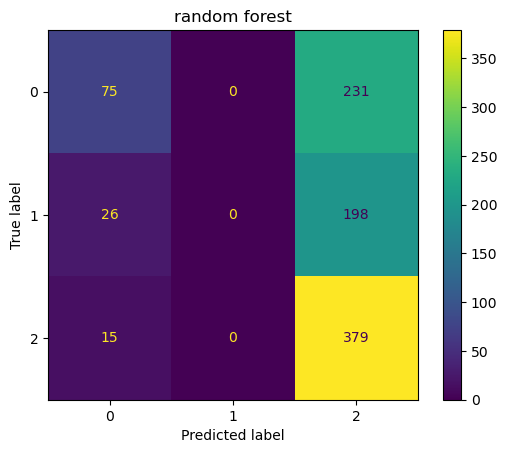

In [92]:
conf_rf= confusion_matrix(y_test,y_pred)
dsp = ConfusionMatrixDisplay(conf_rf)
dsp.plot()
plt.title("random forest")
plt.show()

Gradianet Boosting

In [93]:
y_train_copy = y_train
y_train_copy = np.where(y_train == -1,2,y_train)
print(y_train_copy)
print(y_train)

[2 1 1 ... 1 1 2]
[-1  1  1 ...  1  1 -1]


In [94]:
y_train_gb = np.where(y_train == -1,2,y_train)

In [164]:
gradient_boosting.fit(data_for_sklearn(X_train),(y_train_gb))

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)
c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:22] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, loss='log_loss',
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [167]:
fmap = []
for key in colname_to_int.keys():
    fmap.append(str(key))
feature_map = '\n'.join([f"{i}\t{name}\tq" for i, name in enumerate(fmap)])
with open("feature_map.txt", "w") as f:
    f.write(feature_map)

In [ ]:

gradient_boosting.get_booster().get_score(fmap="D:\\Studia\\studia_mgr\\Sem2\\Owsir\\Projekt\\feature_map.txt" ,importance_type='weight')


XGBoostError: [20:16:33] D:\bld\xgboost-split_1733179535861\work\src\c_api\c_api_utils.h:254: Check failed: feature_map.Size() == n_features (46 vs. 214) : 

: 

In [97]:
gradient_boosting.get_booster().get_score(importance_type='cover')

{'f0': 52.32344055175781,
 'f1': 346.1372985839844,
 'f2': 665.7095947265625,
 'f3': 556.9674072265625,
 'f4': 468.2278137207031,
 'f5': 211.26553344726562,
 'f7': 255.9362030029297,
 'f8': 1067.2420654296875,
 'f9': 513.2271728515625,
 'f10': 693.3281860351562,
 'f11': 712.312255859375,
 'f12': 532.582763671875,
 'f13': 15.444305419921875,
 'f14': 862.720947265625,
 'f15': 933.9006958007812,
 'f16': 286.6145935058594,
 'f17': 684.896728515625,
 'f19': 759.1475219726562,
 'f20': 548.6841430664062,
 'f21': 227.75823974609375,
 'f22': 938.5747680664062,
 'f23': 145.63768005371094,
 'f25': 1070.81884765625,
 'f26': 53.81728744506836,
 'f28': 1075.885009765625,
 'f29': 1343.539306640625,
 'f30': 168.00698852539062,
 'f31': 190.3165740966797,
 'f32': 696.5979614257812,
 'f33': 810.9358520507812,
 'f35': 82.84700012207031,
 'f36': 520.1668090820312,
 'f37': 649.4661254882812,
 'f38': 396.135009765625,
 'f40': 563.8828125,
 'f41': 1111.951416015625,
 'f42': 86.4754867553711,
 'f43': 512.81396

In [98]:
gradient_boosting.get_booster().get_score(importance_type='gain')

{'f0': 3.9382143020629883,
 'f1': 2.099790334701538,
 'f2': 2.5970804691314697,
 'f3': 7.482959270477295,
 'f4': 3.384352684020996,
 'f5': 3.0183775424957275,
 'f7': 1.720047950744629,
 'f8': 2.9315085411071777,
 'f9': 5.6972880363464355,
 'f10': 4.120362758636475,
 'f11': 3.2354748249053955,
 'f12': 3.055907726287842,
 'f13': 2.838742733001709,
 'f14': 3.5628788471221924,
 'f15': 2.1455984115600586,
 'f16': 2.804166793823242,
 'f17': 2.446922779083252,
 'f19': 3.0227468013763428,
 'f20': 2.6978514194488525,
 'f21': 3.8183963298797607,
 'f22': 2.7139127254486084,
 'f23': 3.1420018672943115,
 'f25': 1.8472005128860474,
 'f26': 2.798384666442871,
 'f28': 2.606809616088867,
 'f29': 1.5493546724319458,
 'f30': 4.3201470375061035,
 'f31': 2.983201265335083,
 'f32': 3.0375747680664062,
 'f33': 2.212590456008911,
 'f35': 3.640691041946411,
 'f36': 3.332972764968872,
 'f37': 3.696674108505249,
 'f38': 2.7553484439849854,
 'f40': 2.685718059539795,
 'f41': 2.4294254779815674,
 'f42': 3.15657234

In [99]:
y_pred = gradient_boosting.predict(data_for_sklearn(X_test))

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


In [100]:
y_test_gb = np.where(y_test == -1,2,y_test)

In [101]:
gdb_acc = accuracy_score(y_test_gb,y_pred)
print(gdb_acc)

0.5909090909090909


In [102]:
gdb_prec = precision_score(y_test_gb,y_pred,average='weighted')
print(gdb_prec)

0.5625908994986032


In [103]:
gdb_f1 = f1_score(y_test_gb,y_pred,average="weighted")
print(gdb_f1)

0.569431011572066


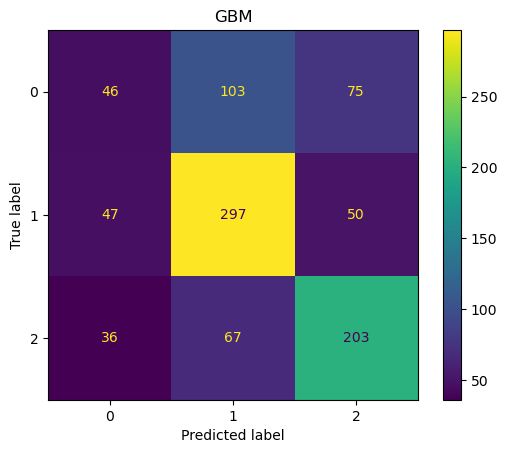

In [104]:
conf_gb= confusion_matrix(y_test_gb,y_pred)
dsp = ConfusionMatrixDisplay(conf_gb)
dsp.plot()
plt.title("GBM")
plt.show()

Sieć neuronowa

In [105]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
history = match_predictor.fit(
    x_train_nn, y_train_nn,
    validation_data=(x_val_nn, y_val_nn),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 1s 6ms/step - loss: 209563.5000 - accuracy: 0.4398 - val_loss: 59.4156 - val_accuracy: 0.4595
Epoch 2/50
93/93 [==============================] - 0s 3ms/step - loss: 220.4936 - accuracy: 0.4899 - val_loss: 5.0200 - val_accuracy: 0.4595
Epoch 3/50
93/93 [==============================] - 0s 3ms/step - loss: 301.7153 - accuracy: 0.4953 - val_loss: 4.9714 - val_accuracy: 0.4595
Epoch 4/50
93/93 [==============================] - 0s 3ms/step - loss: 46.8810 - accuracy: 0.4976 - val_loss: 4.9266 - val_accuracy: 0.4595
Epoch 5/50
93/93 [==============================] - 0s 2ms/step - loss: 94.1602 - accuracy: 0.4973 - val_loss: 4.9008 - val_accuracy: 0.4595
Epoch 6/50
93/93 [==============================] - 0s 3ms/step - loss: 245.7474 - accuracy: 0.4986 - val_loss: 4.8906 - val_accuracy: 0.4595
Epoch 7/50
93/93 [==============================] - 0s 2ms/step - loss: 6.6267 - accuracy: 0.4980 - val_loss: 4.8577 - val_accuracy: 0.4595
Epoch 

In [106]:
X_test_nn = data_for_sklearn(X_test)
y_pred = match_predictor.predict(X_test_nn)

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


In [107]:
y_pred = np.array([np.argmax(x) for x in y_pred])

In [108]:
# y_test_nn = np.array([simple_encode(row) for row in y_test])
nn_accuracy = accuracy_score(y_test_gb,y_pred)
print(nn_accuracy)

0.24242424242424243


In [109]:
nn_precision = precision_score(y_test_gb,y_pred,average='weighted')
print(nn_precision)

0.05876951331496786


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
nn_f1_score = f1_score(y_test_gb,y_pred,average='weighted')
print(nn_f1_score)

0.09460458240946047


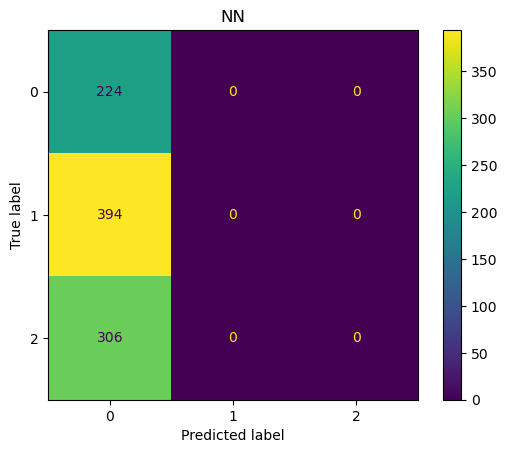

In [111]:
conf_nn= confusion_matrix(y_test_gb,y_pred)
dsp = ConfusionMatrixDisplay(conf_nn)
dsp.plot()
plt.title("NN")
plt.show()

Modele bazujące na embedingach

extracting emebedings

In [112]:
def extract_all_embeddings(model, input_data):
    embeddings = {}
    for layer in model.layers:
        if isinstance(layer, keras.layers.Embedding):
            embedding_model = keras.Model(inputs=model.input, outputs=layer.output)
            embeddings[layer.name] = embedding_model.predict(input_data)
    return embeddings

In [113]:
embedings_train = extract_all_embeddings(model,X_train)

In [114]:
embedings_test = extract_all_embeddings(model,X_test)

In [115]:
embeding_xtrain = data_for_sklearn(embedings_train)
embeding_xtest = data_for_sklearn(embedings_test)
    

C:\Users\stasi\AppData\Local\Temp\ipykernel_29356\368773467.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  dict_forsk = np.hstack(dict[feature] for feature in features)


svm

In [116]:
svm = SVC(C=c,kernel=kernel,gamma=gamma_svm)
random_forest = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_sample_split,criterion=criterion)
gradient_boosting = xgb.XGBClassifier(loss=loss,learning_rate=learning_rate,n_estimators=n_estimators_gb,max_depth=max_depth,gamma=gamma_gb,reg_lambda=reg_lambda)

In [117]:
print(embeding_xtrain.shape[2])

4


In [118]:
embeding_xtrain = embeding_xtrain.reshape((embeding_xtrain.shape[0],embeding_xtrain.shape[1]*embeding_xtrain.shape[2]))

In [119]:
embeding_xtest = embeding_xtest.reshape((embeding_xtest.shape[0],embeding_xtest.shape[1]*embeding_xtest.shape[2]))

In [120]:
svm.fit(embeding_xtrain,y_train)

SVC(C=5, gamma=0.2)

In [121]:
y_pred = svm.predict(embeding_xtest)

In [122]:
svm_acc = accuracy_score(y_test,y_pred)
print(svm_acc)

0.4751082251082251


In [123]:
svc_prec = precision_score(y_test,y_pred,average='weighted')
print(svc_prec)

0.371310873035011


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [124]:
svc_f1 = f1_score(y_test,y_pred,average='weighted')
print(svc_f1)

0.3838446686878743


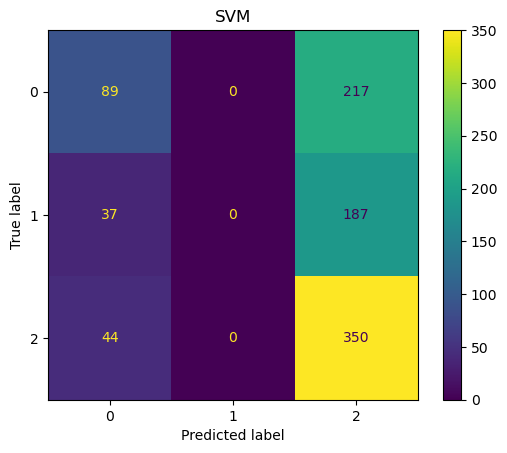

In [125]:
conf_svm = confusion_matrix(y_test,y_pred)
dsp = ConfusionMatrixDisplay(conf_svm)
dsp.plot()
plt.title("SVM")
plt.show()

Random forest 

In [126]:
random_forest.fit(embeding_xtrain,y_train)

RandomForestClassifier(criterion='log_loss', max_depth=3, n_estimators=250)

In [127]:
y_pred= random_forest.predict(embeding_xtest)

In [128]:
random_forest_acc = accuracy_score(y_test,y_pred)
print(random_forest_acc)

0.4902597402597403


In [129]:
random_forest_prec = precision_score(y_test,y_pred,average='weighted')
print(random_forest_prec)

0.3754858799494521


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [130]:
random_forest_f1_score = f1_score(y_test,y_pred,average='weighted')
print(random_forest_f1_score)

0.4123572580495546


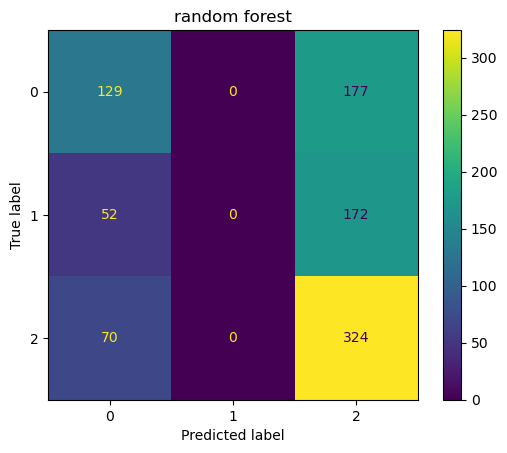

In [131]:
conf_rf = confusion_matrix(y_test,y_pred)
dsp = ConfusionMatrixDisplay(conf_rf)
dsp.plot()
plt.title("random forest")
plt.show()

Gradient Boosting 

In [132]:
gradient_boosting.fit(embeding_xtrain,y_train_gb)
y_pred = gradient_boosting.predict(embeding_xtest) 

c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:20] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


In [133]:
gradient_boosting.get_booster().get_score(importance_type='weight')

{'f0': 179.0,
 'f1': 519.0,
 'f2': 220.0,
 'f3': 560.0,
 'f4': 297.0,
 'f5': 537.0,
 'f6': 558.0,
 'f7': 280.0}

In [134]:
gradient_boosting.get_booster().get_score(importance_type='cover')


{'f0': 830.6493530273438,
 'f1': 850.6638793945312,
 'f2': 410.0512390136719,
 'f3': 1108.6527099609375,
 'f4': 486.7527770996094,
 'f5': 391.8661193847656,
 'f6': 639.8135375976562,
 'f7': 531.3206176757812}

In [135]:
gradient_boosting.get_booster().get_score(importance_type='gain')

{'f0': 9.341593742370605,
 'f1': 4.838206768035889,
 'f2': 3.337278366088867,
 'f3': 22.73017692565918,
 'f4': 3.3583590984344482,
 'f5': 4.78817892074585,
 'f6': 5.288654327392578,
 'f7': 5.101027488708496}

In [136]:
gdb_acc = accuracy_score(y_test_gb,y_pred)
print(gdb_acc)

0.48593073593073594


In [137]:
gdb_prec = precision_score(y_test_gb,y_pred,average='weighted')
print(gdb_prec)

0.37239985779949897


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [138]:
gdb_f1 = f1_score(y_test_gb,y_pred,average='weighted')
print(gdb_f1)

0.40519869654787194


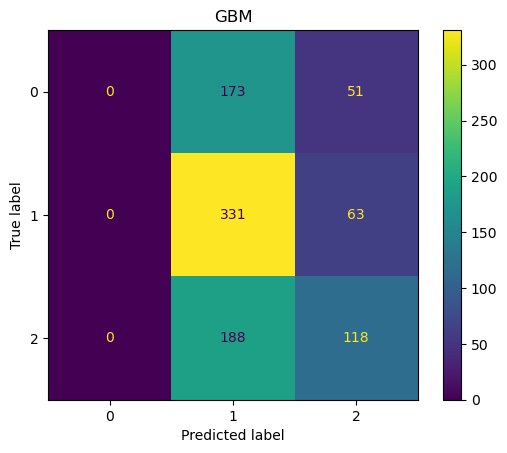

In [139]:
conf_gb = confusion_matrix(y_test_gb,y_pred)
dsp = ConfusionMatrixDisplay(conf_gb)
dsp.plot()
plt.title('GBM')
plt.show()

neural network

In [140]:
x_train_nn,x_val_nn,y_train_nn,y_val_nn = train_test_split(embeding_xtrain,y_train,test_size=0.2,shuffle=False)
y_train_nn = np.array([ simple_encode(row) for row in y_train_nn])
y_val_nn = np.array([simple_encode(row) for row in y_val_nn])
x_train_nn =  np.array(x_train_nn)
x_val_nn =  np.array(x_val_nn)
input_shape=x_train_nn.shape[1]
# input_shape = len(X_train.keys())
match_predictor = Sequential([
        layers.InputLayer(input_shape=input_shape),
        # layers.Dense(512,activation='swish', kernel_regularizer=l2(0.01)),
        # layers.Dropout(0.3),
        # layers.Dense(128,activation='swish', kernel_regularizer=l2(0.01)),
        # layers.Dropout(0.3),
        layers.Dense(8,activation = 'swish',kernel_regularizer=l2(0.01)),
        # layers.Dropout(0.3),
        # # layers.Dense(128,activation = 'relu',kernel_regularizer=l2(0.01)),
        # # layers.Dropout(0.3),
        # layers.Dense(64,activation = 'relu',kernel_regularizer=l2(0.01)),
        # layers.Dropout(0.3),
        # layers.Dense(32,activation = 'relu',kernel_regularizer=l2(0.01)),
        # layers.Dropout(0.2),
        # layers.Dense(16,activation = 'relu',kernel_regularizer=l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(3,activation='softmax'),
    ])
learning_rate = 0.0001
match_predictor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss = 'categorical_crossentropy',metrics='accuracy')
match_predictor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 27        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [141]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
history = match_predictor.fit(
    x_train_nn, y_train_nn,
    validation_data=(x_val_nn, y_val_nn),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 1s 4ms/step - loss: 1.1832 - accuracy: 0.3877 - val_loss: 1.1759 - val_accuracy: 0.4257
Epoch 2/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1739 - accuracy: 0.4137 - val_loss: 1.1692 - val_accuracy: 0.4473
Epoch 3/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1653 - accuracy: 0.4479 - val_loss: 1.1631 - val_accuracy: 0.4568
Epoch 4/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1613 - accuracy: 0.4685 - val_loss: 1.1572 - val_accuracy: 0.4500
Epoch 5/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1523 - accuracy: 0.4841 - val_loss: 1.1515 - val_accuracy: 0.4527
Epoch 6/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1466 - accuracy: 0.5014 - val_loss: 1.1462 - val_accuracy: 0.4581
Epoch 7/50
93/93 [==============================] - 0s 2ms/step - loss: 1.1396 - accuracy: 0.5074 - val_loss: 1.1411 - val_accuracy: 0.4635
Epoch 8/50
93/93 [==

In [142]:

y_pred = match_predictor.predict(embeding_xtest)

In [143]:
y_pred = np.array([np.argmax(x) for x in y_pred])

In [144]:
nn_accuracy = accuracy_score(y_test_gb,y_pred)
print(nn_accuracy)

0.27380952380952384


In [145]:
nn_precision = precision_score(y_test_gb,y_pred,average='weighted')
print(nn_precision)

0.23191869523391262


c:\Users\stasi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [146]:
nn_f1_score = f1_score(y_test_gb,y_pred,average='weighted')
print(nn_f1_score)

0.1759394720634151


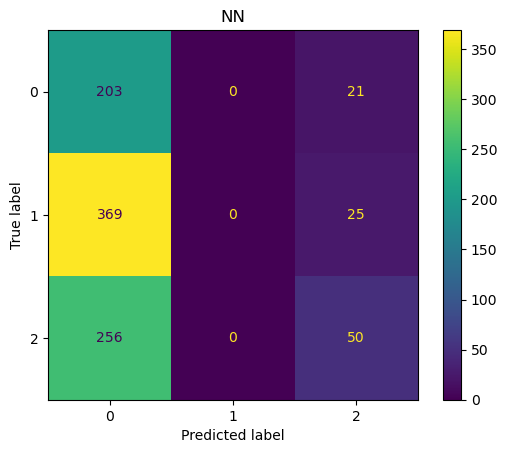

In [147]:
conf_nn= confusion_matrix(y_test_gb,y_pred)
dsp = ConfusionMatrixDisplay(conf_nn)
dsp.plot()
plt.title("NN")
plt.show()